## Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusion](#conclusion)


<a id='intro'></a>
### Introduction

This is the final project of Udacity's Data Analyst Nanodegree Program (Part I). The project will go over a A/B test run for an e-commerice website.


<a id='probability'></a>
#### Part I - Probability

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

Read in the provided dataset

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


Determine the number of rows in the data

In [3]:
df.shape[0]

294478

Determine the number of unique users

In [4]:
df['user_id'].nunique()

290584

Determine proportion of converted users

In [5]:
df['converted'].mean()

0.11965919355605512

Identify the mismatches of `new_page` and `treatment` in the dataset (record with `new_page` should also have `treatment` as a value)

In [6]:
df[((df['landing_page']=='new_page')&(df['group']!='treatment'))|\
  ((df['landing_page']!='new_page')&(df['group']=='treatment'))]['user_id'].count()

3893

Check for null

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

Removing the bad mismatches identified above

In [8]:
df2 = df[((df['landing_page']=='new_page')&(df['group']=='treatment'))|\
  ((df['landing_page']=='old_page')&(df['group']=='control'))]

df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


Double Check all of the correct rows were removed - this should be 0


In [9]:
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page'))\
    == False].shape[0]

0

Determine number of unique users in the new dataset

In [10]:
df2['user_id'].nunique()

290584

Identify duplicate user_id

In [11]:
df2['is_duplicated'] = df2.duplicated(['user_id'])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [12]:
df2[df2['is_duplicated']==True]

,user_id,timestamp,group,landing_page,converted,is_duplicated
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0,True


In [13]:
df2[df2['user_id']==773192]

,user_id,timestamp,group,landing_page,converted,is_duplicated
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0,False
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0,True


Remove duplicate id

In [14]:
df2.drop(1899, inplace=True)

df2[df2['user_id']==773192]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,user_id,timestamp,group,landing_page,converted,is_duplicated
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0,True


Calculate conversion rate of a user (regardless of which group they belong)

In [15]:
df2[df2['converted']==1].shape[0]/df2.shape[0]

0.11959708724499628

Calculate conversion rate of users given that they are in `control` group<br/>
P(Converted|Control) = P(Converted and Control) / P(Control)

In [16]:
#Calculate P(Converted and Control)
p_cnc = df2[(df2['converted']==1)&(df2['group']=='control')].shape[0]/\
df2.shape[0]

#Calculate P(Control)
p_control = df2[(df2['group']=='control')].shape[0]/\
df2.shape[0]

p_cnc/p_control

0.12038630450046119

Calculate conversion rate of users given that they are in `treatment` group<br/>
P(Converted|Treatment) = P(Converted and Treatment) / P(Treatment)

In [17]:
#Calculate P(Converted and Treatment)
p_cnt = df2[(df2['converted']==1)&(df2['group']=='treatment')].shape[0]/\
df2.shape[0]

#Calculate P(Treatment)
p_treatment = df2[(df2['group']=='treatment')].shape[0]/\
df2.shape[0]

p_cnt/p_treatment

0.11880806551510564

Calculate probability a user receive the new page

In [18]:
df2[df['landing_page']=='new_page'].shape[0]/df2.shape[0]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


0.5000619442226688

**Conclusion:** there is no siginificant differences in conversion rate between users receive new page and those who receive new page

<a id='ab_test'></a>
### Part II - A/B Test

This section will analyze the test result using hypothesis testing with Type I error rate of 5%.<br/>

$Ho: P_{new} - P_{old} <= 0$ <br/>
$Ha: P_{new} - P_{old} > 0$ <br/>

*in other words <br/>*

**Null Hypothesis: There is no differences between conversion rate between old and new page <br/>
Alternative Hypothesis: Conversion rate for new page is higher than conversion rate for old page** <br/>

We will test whether there is stasitical evidence to reject null hypothesis and accept that the conversion rate for new page is higher than conversion rate for old page

Determine the conversion rate for $p_{new}$ under the null hypothesis 

In [19]:
p_new = df[(df['converted']==1)].shape[0]/df.shape[0]
p_new

0.11965919355605512

Determine the conversion rate for $p_{old}$ under the null hypothesis

In [20]:
p_old = df[(df['converted']==1)].shape[0]/df.shape[0]
p_old

0.11965919355605512

Determine $n_{new}$

In [21]:
df_new = df2[df2['landing_page']=='new_page']
n_new = df_new.shape[0]
n_new

145310

Determine $n_{old}$

In [22]:
df_old = df2[df2['landing_page']=='old_page']
n_old = df_old.shape[0]
n_old

145274

Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null hypothesis.

In [23]:
new_page_converted = np.random.choice([0,1],p=[1-p_new,p_new],size=n_new)
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null hypothesis

In [24]:
old_page_converted = np.random.choice([0,1],p=[1-p_old,p_old],size=n_old)
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

Find $p_{new}$ - $p_{old}$ 

In [25]:
p_new2 = new_page_converted.sum()/len(new_page_converted)
p_old2 = old_page_converted.sum()/len(old_page_converted)
p_new2-p_old2

-0.0016606709785561558

Simulate 10,000 $p_{new}$ - $p_{old}$ values 

In [26]:
p_diffs=[]
for i in range(10000):
    n = np.random.choice([0,1],p=[(1-p_new),p_new],size=n_new).mean()
    o = np.random.choice([0,1],p=[(1-p_old),p_old],size=n_old).mean()
    p_diffs.append(n-o)


Plot a histogram of the simulated values above

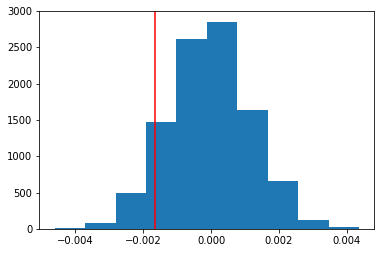

In [27]:
plt.hist(p_diffs)
plt.axvline(p_new2-p_old2, color = 'r')

Calculate the proportion of observed differences versus simulated differences

In [28]:
observed_diffs = df2[df2['group']=='treatment']['converted'].mean() - df2[df2['group']=='control']['converted'].mean()
observed_diffs

-0.0015782389853555567

In [29]:
p_diffs = np.asarray(p_diffs)

In [30]:
1-(observed_diffs < p_diffs).mean()

0.10019999999999996

**Conclusion:** The value computed above is p-value, or the probability of a sample to achieve the null statistic. In this case, since our p-value is much higher than the standard level of significance (0.0923 > 0.05); we conclude that we do not have enough statistical evidence to reject null hypothesis saying that there are no difference in conversion rate between the old and new page.

**Applying built-in function approach **

In [31]:
import statsmodels.api as sm

convert_old = df2[(df2['landing_page']=='old_page')&(df2['converted']\
                 ==1)]['user_id'].count()
convert_new = df2[(df2['landing_page']=='new_page')&(df2['converted']\
                 ==1)]['user_id'].count()
n_old = df2[df2['landing_page']=='old_page']['user_id'].count()
n_new = df2[df2['landing_page']=='new_page']['user_id'].count()

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [32]:
z_score, p_value = sm.stats.proportions_ztest([convert_new,convert_old],[n_new,n_old],alternative ='larger')

z_score,1-p_value

(-1.3109241984234394, 0.094941687240975514)

**Conclusion:** This approach return the same results as the steps above, we still do not have statistical evidence to reject the null hypohthesis indicating that there is no difference in conversion rate between the old and new page.

<a id='regression'></a>
### Part III - A regression approach

In this section, we will perform logistic regression model in the given data. The reason we use logistic regression is because the outcome `converted` is binary.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a colun for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

Adding an intercept

In [33]:
df2['intercept'] = 1
df2.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,user_id,timestamp,group,landing_page,converted,is_duplicated,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,False,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,False,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,False,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,False,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,False,1


Since `group` is a categorical variable, convert it to dummy so we can account for them in the model

In [34]:
df2['ab_page'] = np.where(df2['group']=='treatment', 1, 0)
df2.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,user_id,timestamp,group,landing_page,converted,is_duplicated,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,False,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,False,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,False,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,False,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,False,1,0


Instantiate and fit the Logistic Regression model

In [35]:
log_m = sm.Logit(df2['converted'],df2[['intercept','ab_page']])

r = log_m.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


Provide the summary

In [36]:
r.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 19 Aug 2018   Pseudo R-squ.:               8.077e-06
Time:                        20:34:38   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

**Conclusion:** The p-value of ab_page is 0.190, it is different than the p-value of previous sections because this is a two-tailed test value and therefore is double the p-value of the previous section. $0.190/2 = 0.095$ which is the p-value of the above sections where we were utilizting a one-tail (right-tail) test.

Adding country data into the model to determine if there is an effect of country on conversion rate

In [37]:
df_country = pd.read_csv('countries.csv')
df_country.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


Join country data to the main dataframe

In [38]:
df = df2.set_index('user_id').join(df_country.set_index('user_id'))
df.head()

,timestamp,group,landing_page,converted,is_duplicated,intercept,ab_page,country
user_id,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,False,1,0,US
804228,2017-01-12 08:01:45.159739,control,old_page,0,False,1,0,US
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,False,1,1,US
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,False,1,1,US
864975,2017-01-21 01:52:26.210827,control,old_page,1,False,1,0,US


Convert country values to dummy variables

In [39]:
country = pd.get_dummies(df['country'])
df = df.join(country)
df.head()

,timestamp,group,landing_page,converted,is_duplicated,intercept,ab_page,country,CA,UK,US
user_id,,,,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,False,1,0,US,0,0,1
804228,2017-01-12 08:01:45.159739,control,old_page,0,False,1,0,US,0,0,1
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,False,1,1,US,0,0,1
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,False,1,1,US,0,0,1
864975,2017-01-21 01:52:26.210827,control,old_page,1,False,1,0,US,0,0,1


Instantiate and fit the model with newly added country data

In [40]:
m = sm.Logit(df['converted'],df[['intercept','ab_page','CA','US']])

r = m.fit()

r.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sun, 19 Aug 2018   Pseudo R-squ.:               2.323e-05
Time:                        20:34:39   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9794      0.013   -155.415      0.000      -2.004      -1.954
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0506      0.028     -1.784      0.074      -0.106       0.005
US            -0.0099      0.013     -0.743      0.457      -0.036       0.016
==============================================================================
"""

**Conclusion:** The p-value of country are above our siginificance level 5%. As a result, we cannot reject the null hypothesis that there is no linear relaionship between conversion rate and conversion rate

Adding the interaction term between page and country on conversion rate to account for the effects of these two variable on each other

In [41]:
df['US*page'] = df['US']*df['ab_page']
df['CA*page'] = df['CA']*df['ab_page']

df.head()

,timestamp,group,landing_page,converted,is_duplicated,intercept,ab_page,country,CA,UK,US,US*page,CA*page
user_id,,,,,,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,False,1,0,US,0,0,1,0,0
804228,2017-01-12 08:01:45.159739,control,old_page,0,False,1,0,US,0,0,1,0,0
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,False,1,1,US,0,0,1,1,0
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,False,1,1,US,0,0,1,1,0
864975,2017-01-21 01:52:26.210827,control,old_page,1,False,1,0,US,0,0,1,0,0


In [42]:
log_m = sm.Logit(df['converted'],df[['intercept','ab_page','CA','US','US*page','CA*page']])

r = log_m.fit()

r.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sun, 19 Aug 2018   Pseudo R-squ.:               3.482e-05
Time:                        20:34:40   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9922      0.016   -123.457      0.000      -2.024      -1.961
ab_page        0.0108      0.023      0.475      0.635      -0.034       0.056
CA            -0.0118      0.040     -0.296      0.767      -0.090       0.066
US             0.0057      0.019      0.306      0.760      -0.031       0.043
US*page       -0.0314      0.027     -1.181      0.238      -0.084       0.021
CA*page       -0.0783      0.057     -1.378      0.168      -0.190       0.033
==============================================================================
"""

**Conclusion:** With all p-value larger than our signifiance level 5%, we fail to reject the null hypothesis indicating that there is no differences between conversion rate between different country and page.

<a id='conclusion'></a>
## Conclusion 

Based on our analysis using 3 different approaches: probability, A/B testing, and logistic regression, we find that the result does not provide enough statistical evidence to reject the null hypothesis indicating that there is no difference in conversion rate between the new and old page.